In [1]:
!pip install pyspark


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, sum as spark_sum, round as spark_round
import matplotlib.pyplot as plt
import pandas as pd

# Start SparkSession
spark = SparkSession.builder \
    .appName("CottonProductionAnalysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print('✅ Spark session created:', spark)

✅ Spark session created: <pyspark.sql.session.SparkSession object at 0x0000020F7CC84050>


In [8]:
# ===============================================
# 2. Load Dataset
# ===============================================
csv_path = "cotton_prediction.csv.csv"  # update path if needed
df = spark.read.csv(csv_path, header=True, inferSchema=False)
print('Total Rows:', df.count())
df.printSchema()
df.show(5, truncate=False)

Total Rows: 20447
root
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Market: string (nullable = true)
 |-- Commodity: string (nullable = true)
 |-- Variety: string (nullable = true)
 |-- Grade: string (nullable = true)
 |-- Arrival_Date: string (nullable = true)
 |-- Min_Price: string (nullable = true)
 |-- Max_Price: string (nullable = true)
 |-- Modal_Price: string (nullable = true)
 |-- Commodity_Code: string (nullable = true)

+---------+--------+------------+---------+-------+-----+------------+---------+---------+-----------+--------------+
|State    |District|Market      |Commodity|Variety|Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|
+---------+--------+------------+---------+-------+-----+------------+---------+---------+-----------+--------------+
|Telangana|Khammam |Bhadrachalam|Cotton   |G-6    |FAQ  |13/01/2015  |3888     |4050     |3986       |15            |
|Telangana|Khammam |Bhadrachalam|Cotton   |G-6    |FAQ  |

In [4]:
# ===============================================
# 3. Data Cleaning & Feature Engineering
# ===============================================
# Identify numeric columns manually (adjust based on your CSV)
numeric_cols = ['rainfall', 'temperature', 'humidity', 'pesticide_use', 'yield']

# Replace "NA", "NaN", "", or similar non-numeric values with null
for c in numeric_cols:
    if c in df.columns:
        df = df.withColumn(c, when(col(c).isin("NA", "NaN", ""), None).otherwise(col(c)))
        df = df.withColumn(c, col(c).cast("double"))

# Create new derived features
if all(c in df.columns for c in ['rainfall', 'temperature', 'humidity']):
    df = df.withColumn('rain_temp_ratio', col('rainfall') / (col('temperature') + 1))
    df = df.withColumn('humid_temp_diff', col('humidity') - col('temperature'))

# Check missing values
missing_df = df.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
print("🔍 Missing Values:")
missing_df.show(truncate=False)

df.show(5, truncate=False)

🔍 Missing Values:
+-----+--------+------+---------+-------+-----+------------+---------+---------+-----------+--------------+
|State|District|Market|Commodity|Variety|Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|
+-----+--------+------+---------+-------+-----+------------+---------+---------+-----------+--------------+
|0    |0       |0     |0        |0      |0    |0           |0        |0        |0          |0             |
+-----+--------+------+---------+-------+-----+------------+---------+---------+-----------+--------------+

+---------+--------+------------+---------+-------+-----+------------+---------+---------+-----------+--------------+
|State    |District|Market      |Commodity|Variety|Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|
+---------+--------+------------+---------+-------+-----+------------+---------+---------+-----------+--------------+
|Telangana|Khammam |Bhadrachalam|Cotton   |G-6    |FAQ  |13/01/2015  |3888     |4050   

In [5]:
# ===============================================
# 4. Summary Statistics
# ===============================================
df.describe().show()

+-------+---------+--------+------------+---------+----------------+-----+------------+-----------------+-----------------+------------------+--------------+
|summary|    State|District|      Market|Commodity|         Variety|Grade|Arrival_Date|        Min_Price|        Max_Price|       Modal_Price|Commodity_Code|
+-------+---------+--------+------------+---------+----------------+-----+------------+-----------------+-----------------+------------------+--------------+
|  count|    20447|   20447|       20447|    20447|           20447|20447|       20447|            20447|            20447|             20447|         20447|
|   mean|     NULL|    NULL|        NULL|     NULL|           320.0| NULL|        NULL|4236.576906147601|4643.773756541302| 4504.659045336724|          15.0|
| stddev|     NULL|    NULL|        NULL|     NULL|             0.0| NULL|        NULL|1672.013906787442|1861.148758490952|1710.7342250364252|           0.0|
|    min|Telangana| Khammam|Bhadrachalam|   Cotton|1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20652\131755332.py:8: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(corr, cmap='coolwarm', interpolation='none')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20652\131755332.py:8: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(corr, cmap='coolwarm', interpolation='none')


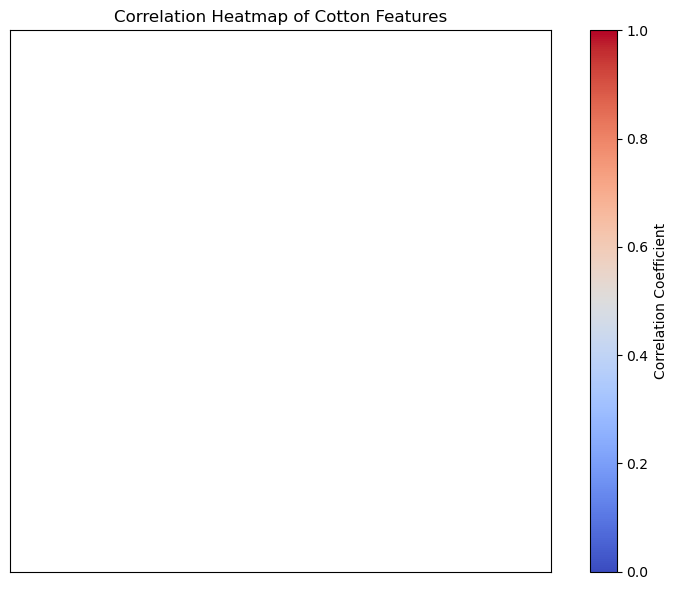

In [6]:
# ===============================================
# 5. Correlation Heatmap (via Pandas)
# ===============================================
numeric_df = df.select([c for c in numeric_cols if c in df.columns]).toPandas()
corr = numeric_df.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Heatmap of Cotton Features")
plt.tight_layout()
plt.show()


In [22]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Define features and label
features = [c for c in numeric_cols if c != 'yield']
if 'yield' in df.columns:
    df_ml = df.na.drop(subset=features + ['yield'])
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    data = assembler.transform(df_ml).select('features', col('yield').alias('label'))

    # Split data
    train, test = data.randomSplit([0.8, 0.2], seed=42)

    # Train model
    lr = LinearRegression(featuresCol='features', labelCol='label')
    lr_model = lr.fit(train)
    predictions = lr_model.transform(test)

    # Display model coefficients
    print("\n📊 Feature Importances:")
    for f, coef in zip(features, lr_model.coefficients):
        print(f"{f}: {round(coef, 4)}")

    # Model performance
    print("\n📈 Model Performance:")
    print("R²:", round(lr_model.summary.r2, 3))
    print("RMSE:", round(lr_model.summary.rootMeanSquaredError, 3))

In [16]:

output_path = "cleaned_cotton_data.csv"
df.toPandas().to_csv(output_path, index=False)
print(f"✅ Cleaned dataset saved to: {output_path}")

✅ Cleaned dataset saved to: cleaned_cotton_data.csv


In [23]:
# ===============================================
# 6. Descriptive Statistics
# ===============================================
print("📊 Basic Statistical Summary of Numeric Columns:")
df.describe().show(truncate=False)



📊 Basic Statistical Summary of Numeric Columns:
+-------+---------+--------+------------+---------+----------------+-----+------------+-----------------+-----------------+------------------+--------------+
|summary|State    |District|Market      |Commodity|Variety         |Grade|Arrival_Date|Min_Price        |Max_Price        |Modal_Price       |Commodity_Code|
+-------+---------+--------+------------+---------+----------------+-----+------------+-----------------+-----------------+------------------+--------------+
|count  |20447    |20447   |20447       |20447    |20447           |20447|20447       |20447            |20447            |20447             |20447         |
|mean   |NULL     |NULL    |NULL        |NULL     |320.0           |NULL |NULL        |4236.576906147601|4643.773756541302|4504.659045336724 |15.0          |
|stddev |NULL     |NULL    |NULL        |NULL     |0.0             |NULL |NULL        |1672.013906787442|1861.148758490952|1710.7342250364252|0.0           |
|min

In [26]:
# ===============================================
# 7. Distribution of Key Variables
# ===============================================
import seaborn as sns

plt.figure(figsize=(6, 4))
for i, col_name in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(pandas_df[col_name].dropna(), kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col_name}')
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

In [27]:
# ===============================================
# 9. Yearly or Seasonal Trend Analysis
# ===============================================
if 'year' in df.columns:
    trend_df = df.groupBy('year').avg('yield', 'rainfall', 'temperature', 'humidity').orderBy('year')
    trend_pd = trend_df.toPandas()

    plt.figure(figsize=(10,5))
    plt.plot(trend_pd['year'], trend_pd['avg(yield)'], marker='o', label='Average Yield')
    plt.plot(trend_pd['year'], trend_pd['avg(rainfall)'], marker='s', label='Rainfall')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title('Yearly Trends in Yield and Rainfall')
    plt.legend()
    plt.grid(True)
    plt.show()

    


In [29]:
# ===============================================
# 11. Feature Importance / Correlation Ranking
# ===============================================
corr_matrix = pandas_df.corr()['yield'].sort_values(ascending=False)
plt.figure(figsize=(6,4))
corr_matrix.drop('yield', errors='ignore').plot(kind='barh', color='orange')
plt.title('Feature Correlation with Yield')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


ValueError: could not convert string to float: 'Telangana'